In [1]:
#Importing the libraries

from __future__ import print_function

import pandas as pd
import numpy as np
import os

# Pytorch modules used in my code.
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Softmax

# These modules are which I've used for data pre processing and results visulaization.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from matplotlib import pyplot as plt

# This is just for interfacing the training progress.
# from tqdm.autonotebook import tqdm

In [2]:
if torch.cuda.is_available():
    device_available = torch.device("cuda")  
else: 
    device_available = torch.device("cpu")
print(device_available)

cuda


In [9]:

def create_data_csv(data_path, train_set_percentage, validation = False, valid_set_percentage = 0):
    # This function is to create train test and validation subsets from the dataset.
    dataset = pd.read_csv(data_path,header=None)
    print("Shape of dataset: ", dataset.shape)
    dataset_length = len(dataset)

    dataset_classes_number = [0, 0, 0]
    for i in dataset.values[:,0]:
        if(i==1.0):
            dataset_classes_number[0] +=1
        elif i == 2.0:
            dataset_classes_number[1] +=1
        elif i == 3.0:
            dataset_classes_number[2] +=1
        
    print("Total number of points of each class in the dataset: ")
    print("Class 1: ",dataset_classes_number[0])
    print("Class 2: ",dataset_classes_number[1])
    print("Class 3: ",dataset_classes_number[2])

    count1 = 0
    count2 = 0
    count3 = 0
    train_set_class1 = []
    train_set_class2 = []
    train_set_class3 = []
    test_set_class1 = []
    test_set_class2 = []
    test_set_class3 = []
    for row in dataset.values:
        if(row[0]==1.0):
            if (int(dataset_classes_number[0]*train_set_percentage/100)>count1):
                train_set_class1.append(row)
                count1 += 1
            else:
                test_set_class1.append(row)
        elif(row[0]==2.0):
            if (int(dataset_classes_number[1]*train_set_percentage/100)>count2):
                train_set_class2.append(row)
                count2 += 1
            else:
                test_set_class2.append(row)
        elif(row[0]==3.0):
            if (int(dataset_classes_number[2]*train_set_percentage/100)>count3):
                train_set_class3.append(row)
                count3 += 1
            else:
                test_set_class3.append(row)

    print("After test set: total number of points of each class in the train+valid dataset: ")
    print("Class 1: ",count1)
    print("Class 2: ",count2)
    print("Class 3: ",count3)

    train_valid_set = pd.concat([pd.DataFrame(train_set_class1),pd.DataFrame(train_set_class2),pd.DataFrame(train_set_class3)],ignore_index=True)
    
    test_set = pd.concat([pd.DataFrame(test_set_class1),pd.DataFrame(test_set_class2),pd.DataFrame(test_set_class3)],ignore_index=True)


    print("Train + Valid set shape: ", train_valid_set.shape)
    print("Test set shape: ", test_set.shape)
    pd.DataFrame(test_set).to_csv("test.csv", index = False,header =None )

    if(validation ==True):
        print("Validation is True, generating both train.csv and valid.csv")
        dataset_classes_after_test = [(int(dataset_classes_number[0]*train_set_percentage/100)),(int(dataset_classes_number[1]*train_set_percentage/100)),(int(dataset_classes_number[2]*train_set_percentage/100))]
        print("After test set: total number of points of each class in the dataset: ")
        print("Class 1: ",dataset_classes_after_test[0])
        print("Class 2: ",dataset_classes_after_test[1])
        print("Class 3: ",dataset_classes_after_test[2])

        train_valid_set_length = len(train_valid_set)

        
        count1 = 0
        count2 = 0
        count3 = 0
        train_set_class1 = []
        train_set_class2 = []
        train_set_class3 = []
        valid_set_class1 = []
        valid_set_class2 = []
        valid_set_class3 = []
        
        for row in train_valid_set.values:
            if(row[0]==1.0):
                if (int(dataset_classes_after_test[0]*valid_set_percentage/100)>count1):
                    valid_set_class1.append(row)
                    count1 += 1
                else:
                    train_set_class1.append(row)
            elif(row[0]==2.0):
                if (int(dataset_classes_after_test[1]*valid_set_percentage/100)>count2):
                    valid_set_class2.append(row)
                    count2 += 1
                else:
                    train_set_class2.append(row)
            elif(row[0]==3.0):
                if (int(dataset_classes_after_test[2]*valid_set_percentage/100)>count3):
                    valid_set_class3.append(row)
                    count3 += 1
                else:
                    train_set_class3.append(row)

        print("After train set: total number of points of each class in the valid dataset: ")
        print("Class 1: ",count1)
        print("Class 2: ",count2)
        print("Class 3: ",count3)

        train_valid_set = pd.concat([pd.DataFrame(train_set_class1),pd.DataFrame(train_set_class2),pd.DataFrame(train_set_class3)],ignore_index=True)
        
        valid_set = pd.concat([pd.DataFrame(valid_set_class1),pd.DataFrame(valid_set_class2),pd.DataFrame(valid_set_class3)],ignore_index=True)

        print("Train set shape: ", train_valid_set.shape)
        pd.DataFrame(train_valid_set).to_csv("train_valid.csv", index = False, header =None)

        validation_set = train_valid_set.iloc[int(train_set_percentage*train_valid_set_length/100):]
        print("Validation set shape: ", valid_set.shape)
        pd.DataFrame(valid_set).to_csv("valid.csv", index = False,header =None)
    else:
        print("No validation, generating only train.csv")
        pd.DataFrame(train_valid_set).to_csv("train.csv", index = False, header =None)
        


class my_dataset_class(Dataset):
    # Preparing dataset using pytorch's dataset class.
    # I have normalzed the dataset as there are some columns which have values in hundreds.
    def __init__(self, path):
        self.X = (pd.read_csv(path)).values[:,1:]
        self.y = (pd.read_csv(path)).values[:,0]
        self.X = self.X.astype('float32')
        self.X = MinMaxScaler().fit_transform(self.X)
        self.y = LabelEncoder().fit_transform(self.y)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


class network(nn.Module):
    # Making the model
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(13,7)
        self.output_layer = nn.Linear(7,3)
        self.actication_relu = ReLU()
        self.activation_sigmoid = Sigmoid()
        # self.act3 = Softmax(dim=1)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.actication_relu(x)
        x= self.output_layer(x)
        return x


def training(train_dataloader,model,epochs, learning_rate, validation = False, validation_loader = None, plots = False):
    # Training cell
    # I have used cross entropy loss and Gradient Descent optimizer.
    loss_CE = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=learning_rate/4)

    log_train_loss = []
    log_train_accuracy = []
    log_valid_loss = []
    log_valid_accuracy = []
    epoch_plot_values = []
    for epoch in range(1,epochs+1):
        model.train()
        train_mean_loss = 0
        train_mean_acc = 0
        
        for train_input,train_label in train_dataloader:
            # train_input = train_input.to(device_available)
            # train_label = train_label.to(device_available)
            optimizer.zero_grad()
            train_output = model(train_input.type(torch.FloatTensor))

            loss_val = loss_CE(train_output,train_label)
            train_mean_loss += loss_val.item()
            
            train_acc = calc_accuracy(train_output,train_label)
            train_mean_acc += train_acc 
                
            loss_val.backward()
            optimizer.step()

            if(validation == True):
                with torch.no_grad():
                    valid_mean_loss = 0
                    valid_mean_acc = 0
                    for valid_input,valid_label in valid_loader:
                        # valid_input = valid_input.to(device_available)
                        # valid_label = valid_label.to(device_available)
                        valid_output = model(valid_input.type(torch.FloatTensor))
                        valid_loss = loss_CE(train_output,train_label)
                        valid_acc = calc_accuracy(valid_output,valid_label)
                        valid_mean_acc += valid_acc
                        valid_mean_loss += valid_loss.item() 
                    

        log_train_loss.append((train_mean_loss/len(train_dataloader)))
        log_train_accuracy.append((train_mean_acc/len(train_dataloader)))
        if(validation == True):
            log_valid_loss.append((valid_mean_loss/len(valid_loader)))
            log_valid_accuracy.append((valid_mean_acc/len(valid_loader)))

        epoch_plot_values.append(epoch)
        
        print("Epoch:",epoch)
        print("Training Loss:",train_mean_loss/len(train_dataloader))
        print("Training accuracy:", (train_mean_acc/len(train_dataloader)), "%")
        if(validation == True):
            print("Validation loss:", valid_mean_loss/len(valid_loader))
            print("Valdation Accuracy:", valid_mean_acc/len(valid_loader),"%")
        print("*******************************************************")
        ############################ Early_stopping_condtion ############
        if(validation == True): 
            if((valid_mean_acc/len(valid_loader)) == 100):
                print("Validation accuracy reached 100%, stopping early.")
                break
            elif(len(log_valid_loss)>20):
                if(log_valid_loss[-20]<(sum(log_valid_loss[-20:])/20)):
                    print(sum(log_valid_loss[-20:])/20)
                    print("Validation loss started to increase, stopping early.")
                    
                    break


    if(plots == True):
        f1 = plt.figure(1)
        ax1 = f1.add_subplot(111)

        f2 = plt.figure(2)
        ax2 = f2.add_subplot(111)

        ax1.plot(epoch_plot_values,log_train_loss, '-b', label = 'Train loss')
        if(validation == True):
            ax1.plot(epoch_plot_values,log_valid_loss, '-r', label = 'Validation loss')
            ax1.set_title("Train and Validation losses")
        else:
            ax1.set_title("Train loss")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")

        ax2.plot(epoch_plot_values,log_train_accuracy, '-b', label = 'Train Accuracy')
        if(validation == True):
            ax2.plot(epoch_plot_values,log_valid_accuracy, '-r', label = 'Validation Accuracy')
            ax2.set_title("Train and Validation accuracy")
        else:
            ax2.set_title("Train accuracy")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")

        plt.legend()
        plt.show()

def calc_accuracy(prediction_tensor, true_val_tensor):
    # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
    prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
    _, max_idx = torch.max(prediction_tensor, dim = 1)
    
    true_val = true_val_tensor.tolist()
    predicted_val = max_idx.cpu().numpy()
    
    correct_count = 0
    for i in range(len(true_val)):
        
        if(predicted_val[i]==true_val[i]):
            correct_count += 1
    
    accuracy = (correct_count / len(true_val))*100 
    return accuracy

def prediction(test_dataloader, model):
    # This function is for predicting with help of the trained model.
    correct_label = []
    prediction_dataset = []
    with torch.no_grad():
        model.eval()
        test_accuracy = 0
        for i,(test_input,label) in enumerate(test_dataloader):
            
            output = model(test_input.type(torch.FloatTensor))
            accuracy = calc_accuracy(output,label)
            test_accuracy += accuracy
            output = torch.log_softmax(output, dim = 1)
            _, max_idx = torch.max(output, dim = 1)
            prediction_dataset.append(max_idx.cpu().numpy())
            correct_label.append(label.tolist())
            
    prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
    # print(prediction_dataset)
    # print(correct_label)
    print("Accuracy: ",  test_accuracy/len(test_dataloader))
    return prediction_dataset, correct_label


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver"):
    # This function if for plotting the confusion matrix.
        
    c_map=plt.cm.Greys
    plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

    plt.gcf().set_facecolor(bg_color)
    plt.title(title)

    axes = np.arange(len(classes))

    plt.xticks(axes, classes, rotation=45)
    plt.yticks(axes, classes)

    plt.ylabel(' True wines assigned \n by expert')
    plt.xlabel('\n Predicted Wines')

    thresh = c_matrix.max() / 2.

    for i in range((c_matrix.shape[0])):
        for j in range((c_matrix.shape[1])):
            if c_matrix[i, j] > thresh:
                text_color = "white"  
            else:
                text_color = "black"
            plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
    plt.show()


In [4]:
# Here I've called my function which creates train and test csv. You can set validation = False if you don't need the validation in your code.
validation_status = True
create_data_csv("wine.data", train_set_percentage = 80,validation = validation_status, valid_set_percentage=20)

Shape of dataset:  (178, 14)
Total number of points of each class in the dataset: 
Class 1:  59
Class 2:  71
Class 3:  48
After test set: total number of points of each class in the train+valid dataset: 
Class 1:  47
Class 2:  56
Class 3:  38
Train + Valid set shape:  (141, 14)
Test set shape:  (37, 14)
Validation is True, generating both train.csv and valid.csv
After test set: total number of points of each class in the dataset: 
Class 1:  47
Class 2:  56
Class 3:  38
After train set: total number of points of each class in the valid dataset: 
Class 1:  9
Class 2:  11
Class 3:  7
Train set shape:  (114, 14)
Validation set shape:  (27, 14)


In [13]:
model = network()

# Changing device to GPU if available.
# model = model.to(device_available)
if(os.path.exists("valid.csv")):
    print("Valid.csv found, so validation would be there in training.")
    valid_dataset = my_dataset_class('valid.csv')
    valid_loader = DataLoader(valid_dataset,batch_size = 2, shuffle=True)
    print("Valid Loader", len(valid_loader))
    train_set_name = "train_valid.csv"
else:
    print("No Valid.csv found, so no validation in training.")
    train_set_name = "train.csv"

train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(train_dataset,batch_size = 10, shuffle=True)
print("Train Loader", len(train_loader))


test_dataset = my_dataset_class("test.csv")
test_loader = DataLoader(test_dataset, batch_size=4)
print("Test Loader", len(test_loader))

Valid.csv found, so validation would be there in training.
Valid Loader 13
Train Loader 12
Test Loader 9


Training with validation
Epoch: 1
Training Loss: 1.1091845234235127
Training accuracy: 39.44444444444444 %
Validation loss: 1.1375032663345337
Valdation Accuracy: 42.30769230769231 %
*******************************************************
Epoch: 2
Training Loss: 1.0614587267239888
Training accuracy: 45.55555555555555 %
Validation loss: 1.002846121788025
Valdation Accuracy: 65.38461538461539 %
*******************************************************
Epoch: 3
Training Loss: 0.976031889518102
Training accuracy: 63.333333333333336 %
Validation loss: 0.8172628283500671
Valdation Accuracy: 69.23076923076923 %
*******************************************************
Epoch: 4
Training Loss: 0.8793913871049881
Training accuracy: 62.77777777777778 %
Validation loss: 1.0192018747329712
Valdation Accuracy: 88.46153846153847 %
*******************************************************
Epoch: 5
Training Loss: 0.7474122593800226
Training accuracy: 75.83333333333333 %
Validation loss: 0.5898894667625427
Va

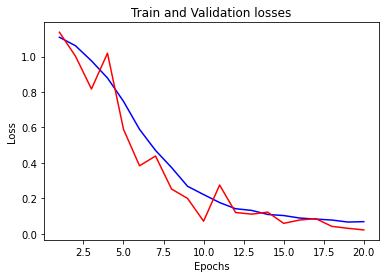

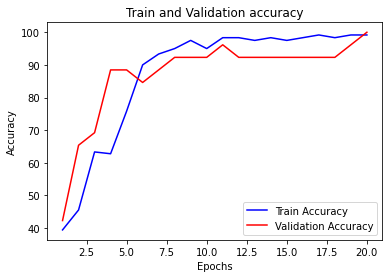

In [14]:
# Calling training function.
if(os.path.exists("valid.csv")):
    print("Training with validation")
    validation_training_status = True
else:
    print("Training without validation")
    validation_training_status = False
    valid_loader = None
    

training(train_loader, model, epochs = 100, learning_rate = 0.2, validation = validation_training_status, validation_loader = valid_loader,plots =True)



Train Loader &lt;class &#39;torch.utils.data.dataloader.DataLoader&#39;&gt;
Accuracy:  99.11504424778761
 
[[37  0  0]
 [ 0 44  1]
 [ 0  0 31]]
 


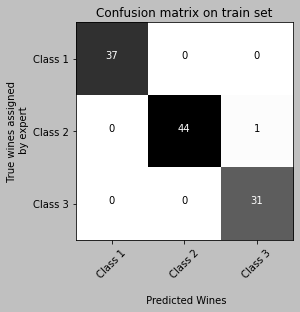

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      0.98      0.99        45
           2       0.97      1.00      0.98        31

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



In [15]:
# Plotting confusion matrix for training

train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(train_dataset,batch_size = 1)
print("Train Loader", type(train_loader))

prediction_dataset, correct_label = prediction(train_loader, model)
prediction_dataset_1D = []
prediction_dataset = np.array(prediction_dataset)
prediction_dataset = prediction_dataset.tolist()


correct_label = np.array(correct_label)
correct_label = correct_label.tolist()
correct_label_1D = []

for i in range(len(correct_label)):
    for j in range((len(correct_label[0]))): 
        correct_label_1D.append(correct_label[i][j])
        



c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2]))

print(" ")
print(c_matrix)
print(" ")
confusion_matrix_plot(c_matrix, classes = ["Class 1","Class 2","Class 3"], title="Confusion matrix on train set" )
print(classification_report(correct_label, prediction_dataset))

Accuracy:  97.22222222222223
 
[[11  0  0]
 [ 0 14  1]
 [ 0  0 10]]
 


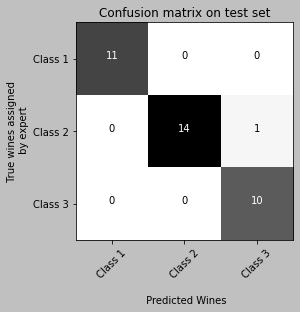

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.93      0.97        15
           2       0.91      1.00      0.95        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



In [16]:
# Testing cell
# Confusion matrix plot and some other metrics like recall, precision and accuracy.

b_s = test_loader.batch_size
length_loader = len(test_loader)
prediction_dataset, correct_label = prediction(test_loader, model)
length_prediction = b_s*length_loader

prediction_dataset = np.array(prediction_dataset)
prediction_dataset.resize([1,length_prediction])
prediction_dataset.squeeze()
prediction_dataset = prediction_dataset.tolist()
prediction_dataset = prediction_dataset[0]


correct_label = np.array(correct_label)
correct_label.resize([1,length_prediction])
correct_label.squeeze()
correct_label = correct_label.tolist()
correct_label = correct_label[0]

c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2]))

print(" ")
print(c_matrix)
print(" ")
confusion_matrix_plot(c_matrix, classes = ["Class 1","Class 2","Class 3"], title="Confusion matrix on test set" )
print(classification_report(correct_label, prediction_dataset))
